# Natural Language Intent to Parameterized Function Calls with Phi-3

This notebook explores mapping natural language intent to parameterized function calls with small language models (SLM). This is 
particularly relevant in edge scenarios where latency and/or connectivity issues make the unavailability of cloud-only solutions infeasible.

To make the scenario more concrete, this evaluation considers a use case that has a lot of traction in the automotive industry: 
an an automotive assistant that helps a driver control non-safety critical systems.  It also focuses the investigation around Phi-3 SLM,
but also consider other SLMs (in particular Llama3) and different sizes of Phi-3 (in particular small and medium) to compare and contrast
the baseline performance of Phi-3 mini with these other SLMs.

Finally, it also considers three different implementation techniques.  Namely, it considers:

1. Llama.cpp (via python wrappers / CUDA accelerated) with direct prompts of the LLM.
2. Llama.cpp (via python wrappers / CUDA accelerated) with guidance managed LLM generation.
2. Ollama HTTP endpoint hosted SLMs with direct prompt usage of the LLM to see if there is a performance benefit.
    
There are three main questions this experiment sought to answer:

1. Can Phi-3 accurately map user natural language intents to parameterized function calls? And how does it compare to other SLMs?
2. Can it achieve this with the low latency required for a fluent user experience?
3. How do different backend hosting and implementation techniques affect latency and correctness?

The performance results for this investigation were captured in an WSL2 Ubuntu environment on an AMD 7950X3D desktop PC 
with an Nvidia RTX4080 GPU.  All configurations were configured to use the GPU for acceleration.

This investigation shows that:

1) Yes, this is feasible with the simple single intent commands we consider here. Phi-3 mini is able to map intent to the 
   correct function with the correct parameters at least 95% of the time with 0% incorrect function (but valid function call) mappings
   that cause the most user confusion.
2) With GPU acceleration, it is possible for Phi-3 to do this mapping in P99 subsecond time.
3) Implementation matters a great deal. This investigation shows that utilizing LLM steering libraries like guidance can 
   both greatly accelerate performance (3.1x to 14.2x) and greatly improve successful outcomes (88.3% -> 98.7%).

Finally, there are many avenues where this work could be extended:

1. Extending the investigation to look at more complex natural language commands like "Please lower the temperature to 59 and increase the fan" to investigate if SLMs can decode these multiple intents into multiple function calls.
2. How do SLMs perform with the typical recognition errors of a speech to text system?


In [7]:
import json

with open('results/model-eval-amd-7950x3d-rtx4080.json', 'r') as file:
    data = json.load(file)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

records = []
for model, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'model': model,
            'tool': tool,
            'pass_percentage': metrics['pass_percentage'],
            'median_latency': metrics['median_latency'],
            'latencies': metrics['latencies'],
            'errors': metrics['errors']
        })

df = pd.DataFrame(records)

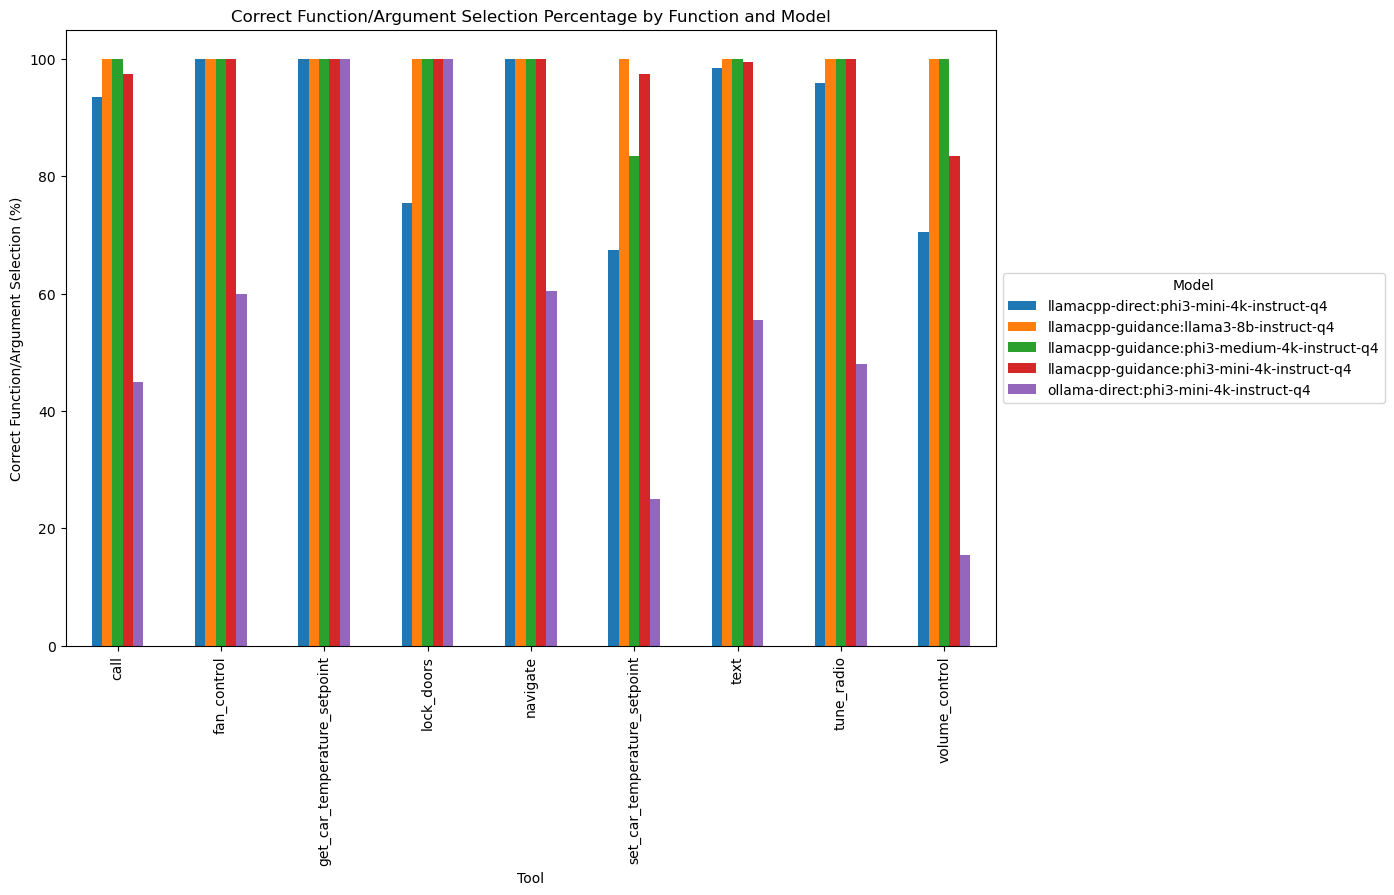

In [9]:

# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Function/Argument Selection Percentage by Function and Model')
plt.xlabel('Tool')
plt.ylabel('Correct Function/Argument Selection (%)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

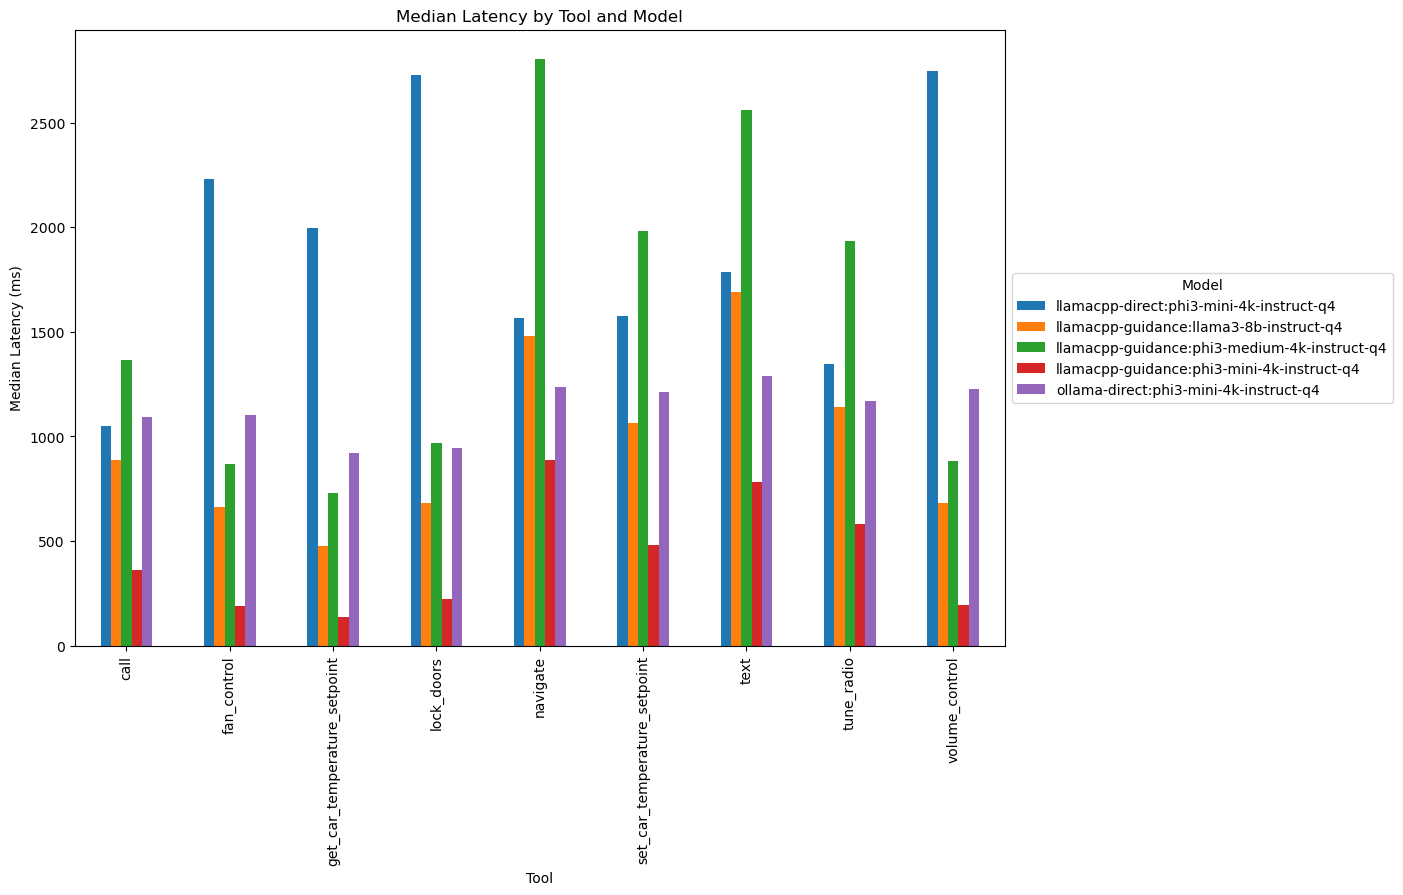

In [10]:
# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool and Model')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

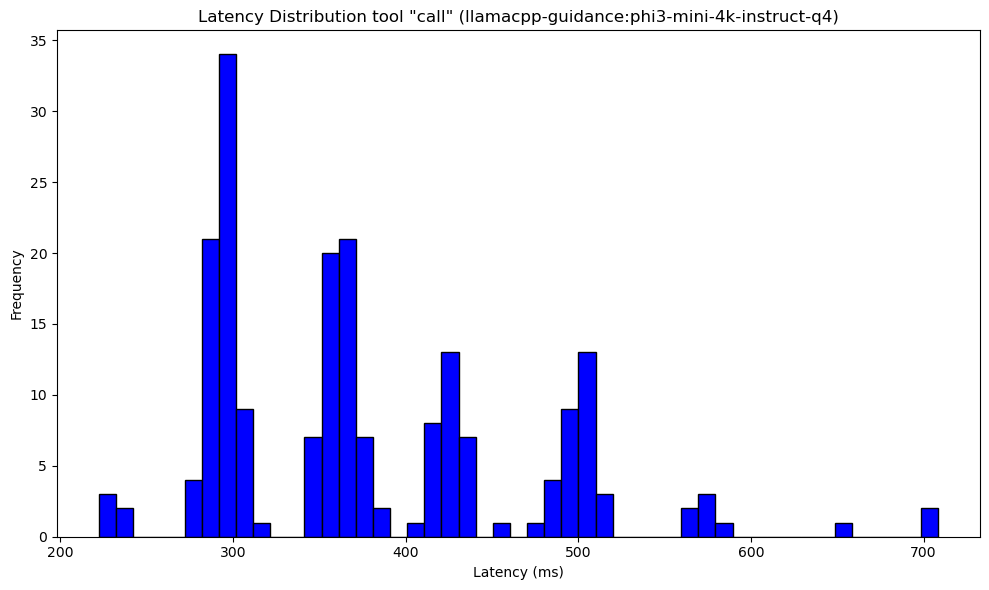

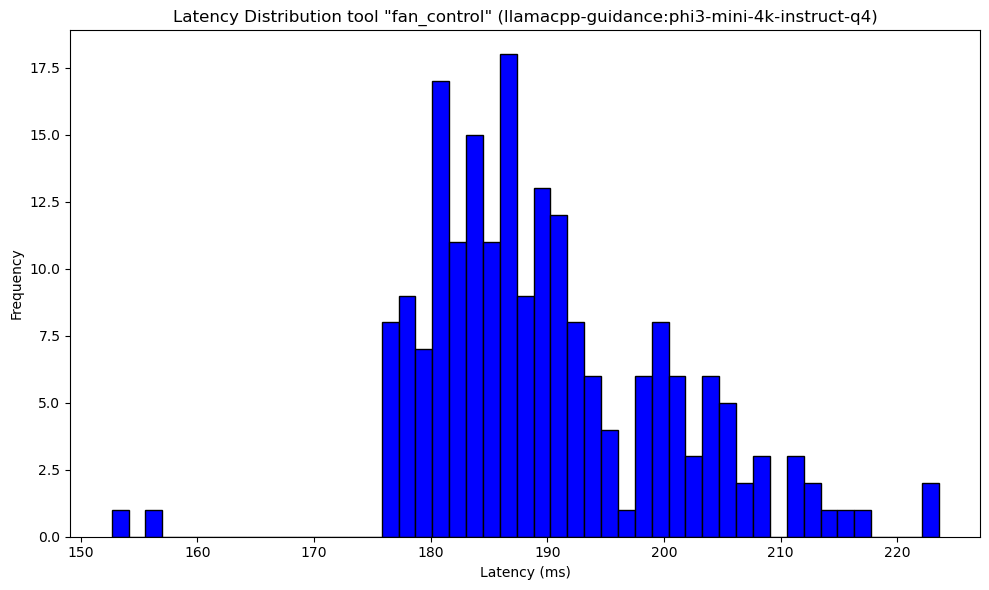

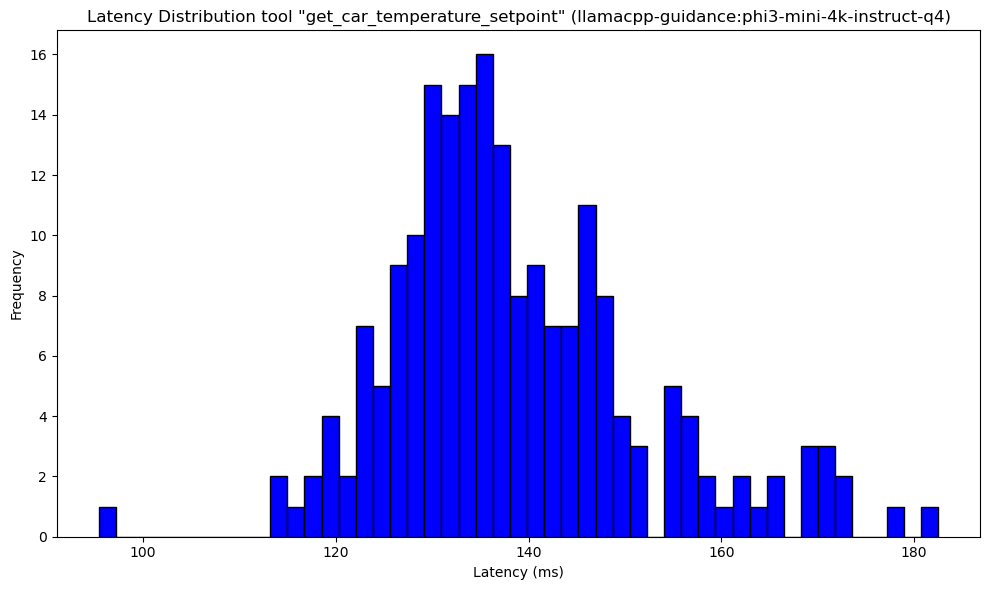

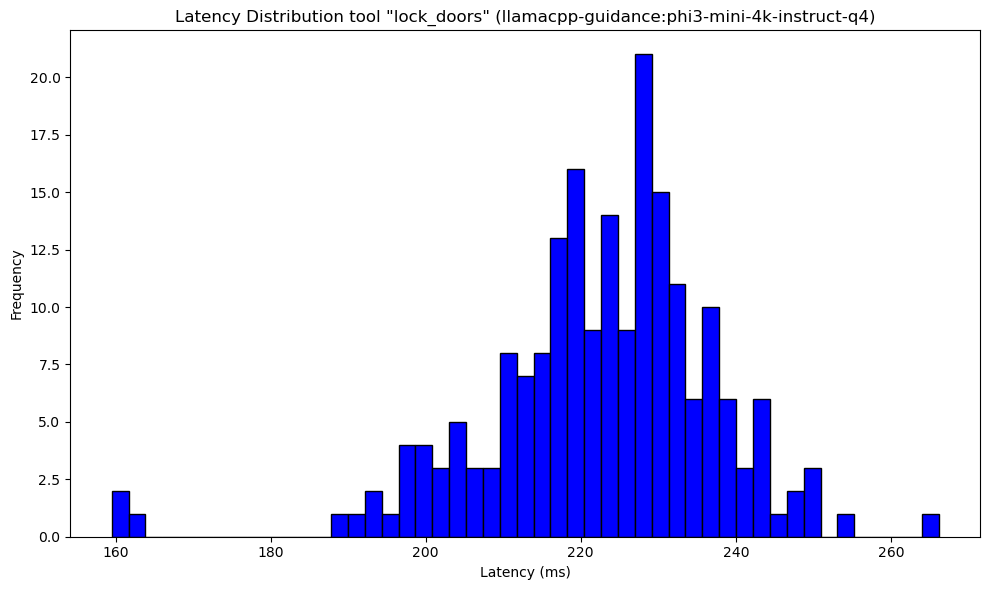

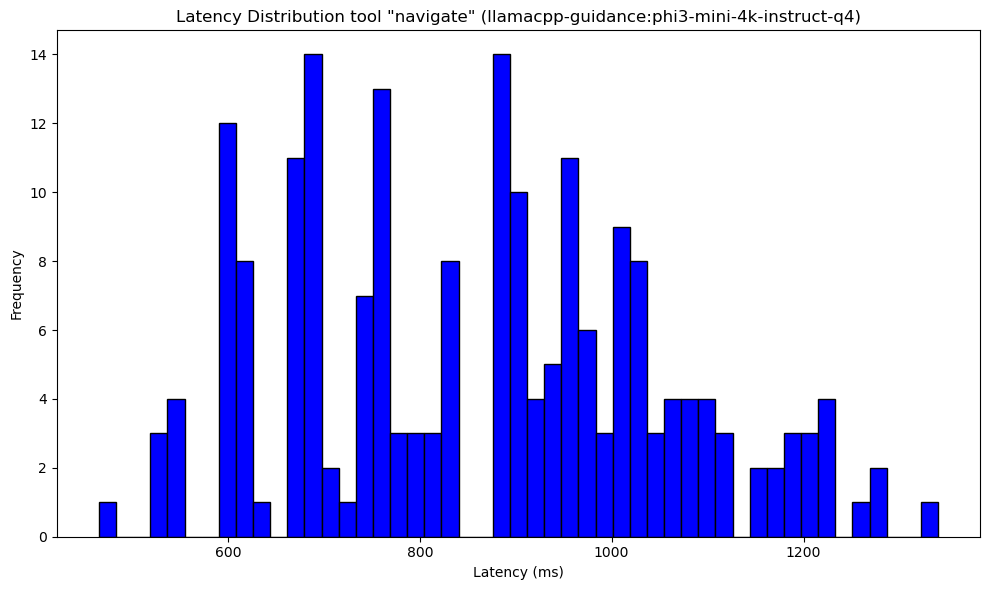

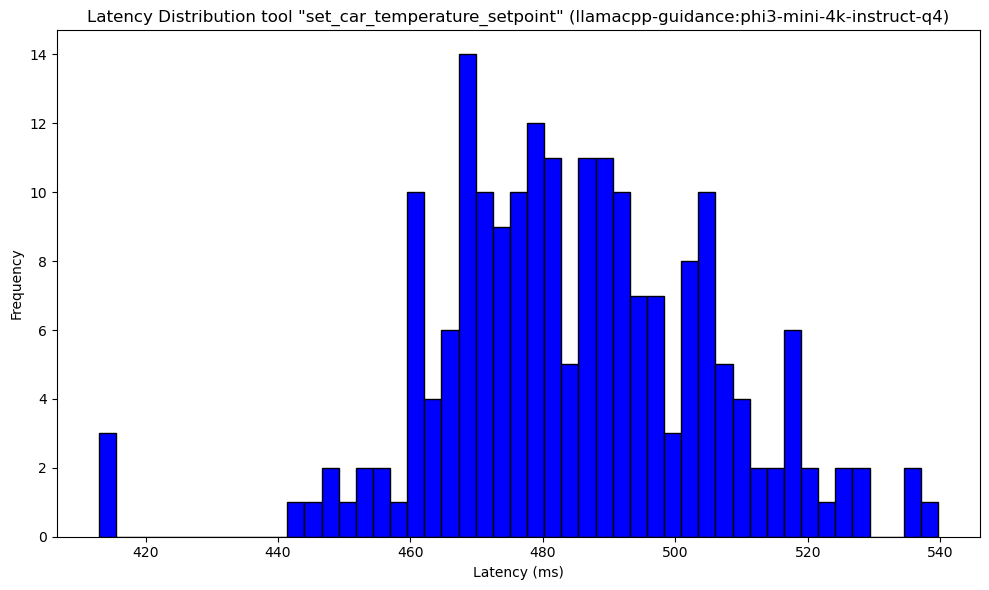

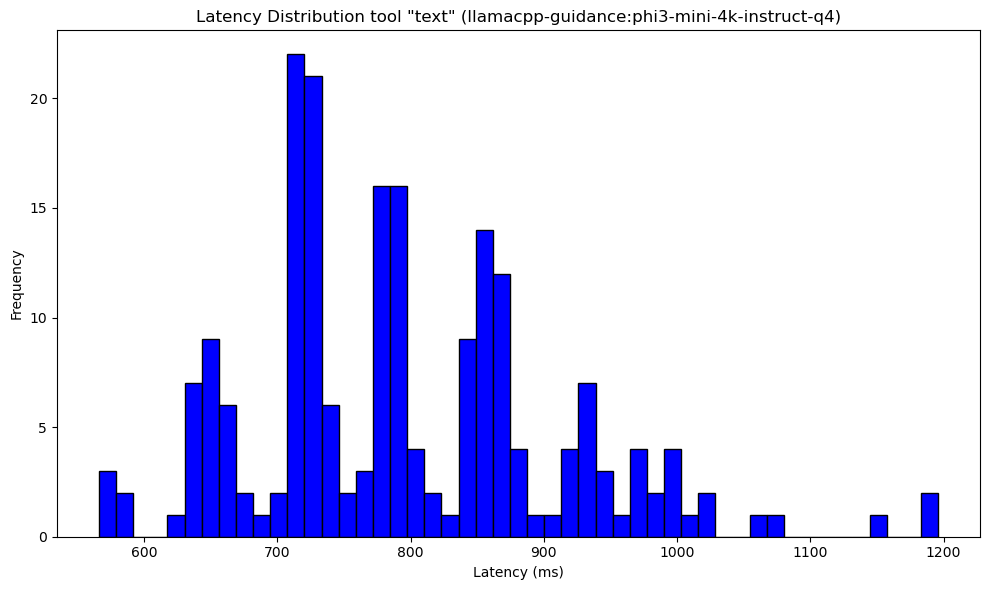

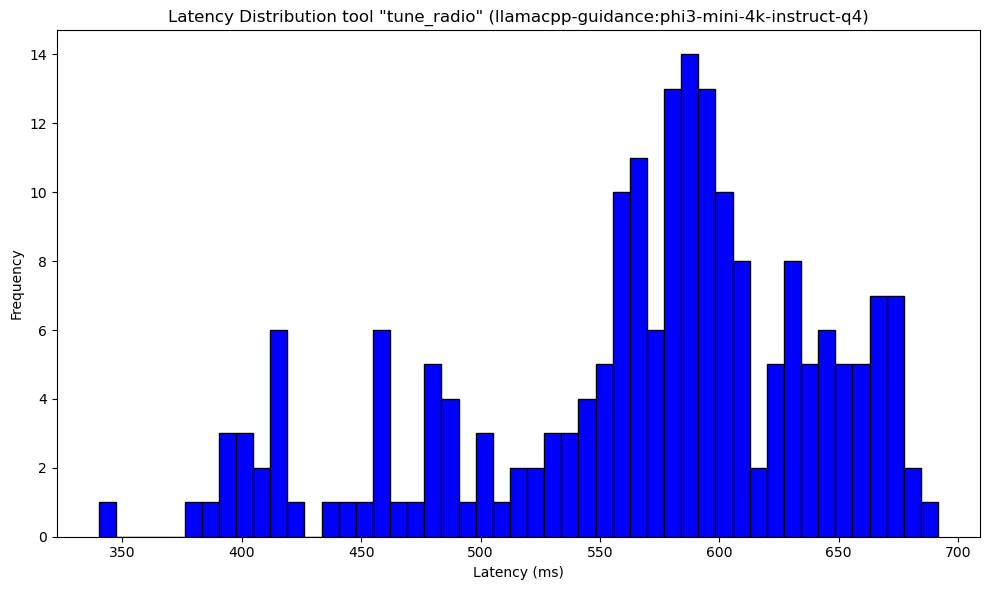

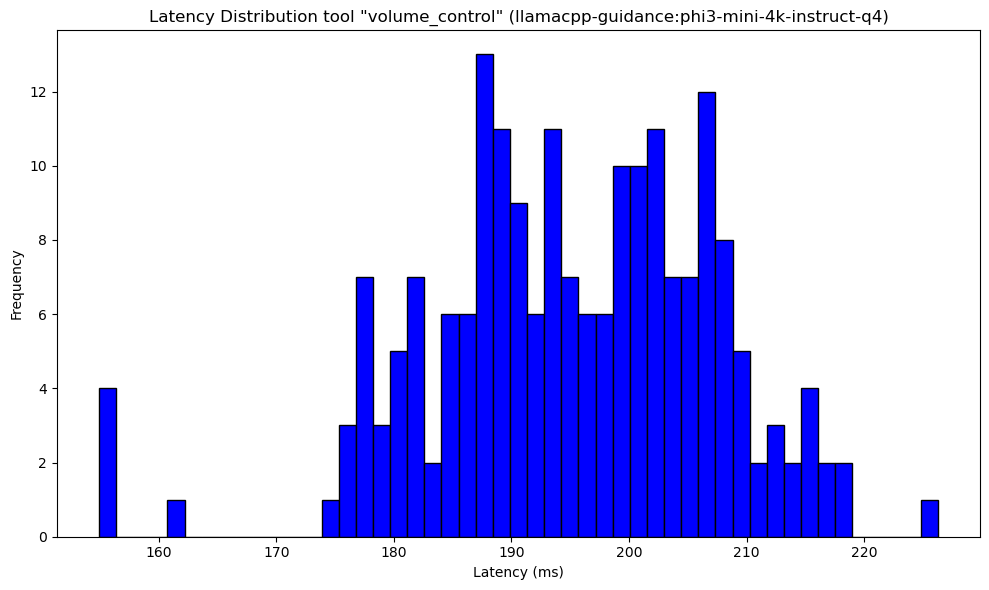

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots are displayed inline
%matplotlib inline

llamacpp_guidance_df = df[df['model'].apply(lambda model: model == "llamacpp-guidance:phi3-mini-4k-instruct-q4")]

for row in llamacpp_guidance_df.iterrows():
    config_name = row[1]['model']
    tool_name = row[1]['tool']
    latencies = row[1]['latencies']

    # Create bins for the histogram
    min_latency = min(latencies)
    max_latency = max(latencies)
    bins = np.linspace(min_latency, max_latency, 50)
    
    # Plotting the latency distribution
    plt.figure(figsize=(10, 6))
    plt.hist(latencies, bins=bins, edgecolor='black', color='blue')
    
    plt.title(f'Latency Distribution tool "{tool_name}" ({config_name})')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Frequency')

    # Adjust layout to ensure no overlapping elements
    plt.tight_layout()
    
    plt.show()

In [12]:
from tabulate import tabulate
from IPython.display import display, HTML

def print_results(results):
    headers = ["f(x)", "p", "fi", "pi", "nfr", "i(bvfc)", "total", "%", "min (ms)", "mean", "median", "max (ms)"]

    data = []
    for pivot in results:
        pivot_results = results[pivot]
        if pivot_results["total_evaluations"] > 0:
            passed = pivot_results["passed"]
            function_incorrect = pivot_results["function_incorrect"]
            parameters_incorrect = pivot_results["parameters_incorrect"]
            non_function_response = pivot_results["non_function_response"]
            total_evaluations = pivot_results["total_evaluations"]
            incorrect_but_valid = pivot_results["incorrect_but_valid"]
            pass_percentage = pivot_results["pass_percentage"]

            min_latency = pivot_results["min_latency"]
            max_latency = pivot_results["max_latency"]
            mean_latency = pivot_results["mean_latency"]
            median_latency = pivot_results["median_latency"]

            data.append([pivot, passed, function_incorrect, parameters_incorrect, non_function_response, incorrect_but_valid, total_evaluations, pass_percentage, min_latency, mean_latency, median_latency, max_latency])  

    print(tabulate(data, headers=headers))
    
for config_tag in data:
    display(HTML(f"<b>{config_tag}</b>"))
    print()
    print_results(data[config_tag])
    print()


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)     mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  -------  --------  ----------
call                          195     0     5      0          0      200   97.5    222.378   376.613   361.176     708.415
fan_control                   200     0     0      0          0      200  100      152.647   189.892   187.682     223.558
get_car_temperature_setpoint  200     0     0      0          0      200  100       95.4263  138.579   136.016     182.496
lock_doors                    200     0     0      0          0      200  100      159.482   222.498   224.403     266.159
navigate                      200     0     0      0          0      200  100      465.507   864.2     886.093    1340.23
set_car_temperature_setpoint  195     0     5      0          0      200   97.5    412.964   484.761   483.252     539.664
text            


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100       970.691  1410.57   1364.71     2365.12
fan_control                   200     0     0      0          0      200  100       420.217   871.365   870.155    1030.13
get_car_temperature_setpoint  200     0     0      0          0      200  100       629.562   738.096   727.942     954.434
lock_doors                    200     0     0      0          0      200  100       444.74    958.789   967.574    1126.26
navigate                      200     0     0      0          0      200  100      1673.54   2767.46   2803.79     4067.55
set_car_temperature_setpoint  167     0    33      0          0      200   83.5    1740.05   1965.98   1982.06     2263.03
text        


f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100     679.394   921.429   886.304    1649.61
fan_control                   200     0     0      0          0      200  100     575.189   674.846   665.027     797.461
get_car_temperature_setpoint  200     0     0      0          0      200  100     400.882   486.516   476.81      633.718
lock_doors                    200     0     0      0          0      200  100     527.19    692.711   683.105     857.413
navigate                      200     0     0      0          0      200  100     945.549  1484.41   1481.92     2144.38
set_car_temperature_setpoint  200     0     0      0          0      200  100     955.475  1074.91   1066.28     1278.41
text                      


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          187     0    13      0          0      200   93.5     803.689   1372.98   1051.64     3205.31
fan_control                   200     0     0      0          0      200  100      1362.2     2003.61   2228.91     2472.06
get_car_temperature_setpoint  200     0     0      0          0      200  100      1428.42    1996.82   1997.71     2376.74
lock_doors                    151     0     0     49          0      200   75.5    1010.06    2038.09   2726.59     3047.18
navigate                      200     0     0      0          0      200  100      1154.59    1553.88   1568.2      2027.98
set_car_temperature_setpoint  135     0     0     65          0      200   67.5    1478.95    1944.03   1575.24    16440.6
text    


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                           90     0   109      1          0      200   45       425.638  1046.22   1092.54      1405.45
fan_control                   120     0    80      0          0      200   60       784.291  1126.41   1103.21      1698.5
get_car_temperature_setpoint  200     0     0      0          0      200  100       460.18    885.528   923.417     1019.98
lock_doors                    200     0     0      0          0      200  100       474.098   964.027   944.803     1128.44
navigate                      121     0    79      0          0      200   60.5     840.193  1234.79   1235.69      1392.33
set_car_temperature_setpoint   50     0   150      0          0      200   25      1111.91   1206.28   1214.4       1353.74
text    

In [13]:
from IPython.display import display, HTML

errors_df = df[df['errors'].apply(lambda x: len(x) > 0)]
headers = ["user", "exp f(x)", "gen f(x)", "exp params", "gen params"]

for index, row in errors_df.iterrows():
    model_name = row['model']
    tool_name = row['tool']
    errors = row['errors']

    display(HTML(f"<b>Errors analysis for {tool_name} with config {model_name}</b>"))
    
    errors_table = []
    for error in errors:
        print()
        user_input = error["user_input"]
        
        expected_function = error["expected_function"]
        generated_function = error["generated_function"]
        
        if expected_function != generated_function:
            print(f"{user_input} -> expected f(x) {expected_function} vs. generated {generated_function}")

        expected_parameters = error["expected_parameters"]
        generated_parameters = error["generated_parameters"]
        
        if expected_parameters != generated_parameters:
            print(f'"{user_input}"')
            print(f"expected params:  {expected_parameters}")
            print(f"generated params: {generated_parameters}")

    print()
        


"Please call Steven Ramirez"
expected params:  {'name': 'Steven Ramirez'}
generated params: {'name': 'Steven Ramiree'}

"Please call Amanda Martinez"
expected params:  {'name': 'Amanda Martinez'}
generated params: {'name': 'Amanda Martinee'}

"Please call Steven Ramirez"
expected params:  {'name': 'Steven Ramirez'}
generated params: {'name': 'Steven Ramiree'}

"Please call Clara Müller"
expected params:  {'name': 'Clara Müller'}
generated params: {'name': 'Clara Muller'}

"Please call Steven Ramirez"
expected params:  {'name': 'Steven Ramirez'}
generated params: {'name': 'Steven Ramiree'}




"Set the air conditioner to 69 degrees."
expected params:  {'temperature': 69}
generated params: {'temperature': 29.0}

"Set the air conditioner to 65 degrees."
expected params:  {'temperature': 65}
generated params: {'temperature': 1.0}

"Set the air conditioner to 65 degrees."
expected params:  {'temperature': 65}
generated params: {'temperature': 1.0}

"Set the air conditioner to 65 degrees."
expected params:  {'temperature': 65}
generated params: {'temperature': 1.0}

"Set the temperature to 69 degrees please"
expected params:  {'temperature': 69}
generated params: {'temperature': 1.0}




"Please text Clara Müller that I am running late"
expected params:  {'name': 'Clara Müller', 'message': 'I am running late'}
generated params: {'name': 'Clara M\\u00fcller', 'message': 'I am running late'}




"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volume to 15"
expected params:  {'volume': '15'}
generated params: {'volume': '30'}

"Set volu


"Please change it to 73 degrees for me."
expected params:  {'temperature': 73}
generated params: {'temperature': 730.0}

"Would you mind putting it at 65 degrees?"
expected params:  {'temperature': 65}
generated params: {'temperature': 650.0}

"Set it at 75 degrees, thanks."
expected params:  {'temperature': 75}
generated params: {'temperature': 750.0}

"Would you mind putting it at 75 degrees?"
expected params:  {'temperature': 75}
generated params: {'temperature': 750.0}

"Adjust it to 65 degrees for me."
expected params:  {'temperature': 65}
generated params: {'temperature': 650.0}

"Set it at 73 degrees, thanks."
expected params:  {'temperature': 73}
generated params: {'temperature': 730.0}

"Please set it to 74 degrees."
expected params:  {'temperature': 74}
generated params: {'temperature': 740.0}

"Set it at 74 degrees, thanks."
expected params:  {'temperature': 74}
generated params: {'temperature': 740.0}

"Please set it to 65 degrees."
expected params:  {'temperature': 65}
ge


"Please call Emily"
expected params:  {'name': 'Emily'}
generated params: [{'name': 'name', 'value': 'Emily'}]

"Please call Jan Kowalski"
expected params:  {'name': 'Jan Kowalski'}
generated params: [{'name': 'name', 'value': 'Jan Kowalski'}]

"Please call Amanda Martinez"
expected params:  {'name': 'Amanda Martinez'}
generated params: {'name': 'Amanda Martinee'}

"Please call Emma"
expected params:  {'name': 'Emma'}
generated params: [{'name': 'name', 'value': 'Emma'}]

"Please call Antonio"
expected params:  {'name': 'Antonio'}
generated params: [{'name': 'name', 'value': 'Antonio'}]

"Please call Emma"
expected params:  {'name': 'Emma'}
generated params: [{'name': 'name', 'value': 'Emma'}]

"Please call Anne"
expected params:  {'name': 'Anne'}
generated params: [{'name': 'name', 'value': 'Anne'}]

"Please call Samantha Allen"
expected params:  {'name': 'Samantha Allen'}
generated params: {'name': 'Samanthe Allen'}

"Please call Emily"
expected params:  {'name': 'Emily'}
generated 


"Please text Samantha Allen that I am running behind"
expected params:  {'name': 'Samantha Allen', 'message': 'I am running behind'}
generated params: {'name': 'Samanthe Allen', 'message': 'I am running behind'}

"Please text Oscar Martínez that I am almost there"
expected params:  {'name': 'Oscar Martínez', 'message': 'I am almost there'}
generated params: {'name': 'Oscar Martinez', 'message': 'I am almost there'}

"Please text Amanda Martinez that I am on my way"
expected params:  {'name': 'Amanda Martinez', 'message': 'I am on my way'}
generated params: {'name': 'Amanda Martinee', 'message': 'I am on my way'}




"Please call Scott"
expected params:  {'name': 'Scott'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Scott'}]

"Please call Peter"
expected params:  {'name': 'Peter'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Peter'}]

"Please call Steven Ramirez"
expected params:  {'name': 'Steven Ramirez'}
generated params: {'name': 'Steven Ramireran'}

"Please call Leif"
expected params:  {'name': 'Leif'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Leif'}]

"Please call Dylan Murphy"
expected params:  {'name': 'Dylan Murphy'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Dylan Murphy'}]

"Please call Benjamin Green"
expected params:  {'name': 'Benjamin Green'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Benjamin Green'}]

"Please call Jeremy"
expected params:  {'name': 'Jeremy'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Jeremy'}]

"Please call János"
expected params:  {'name': 'J


"Set fan to full"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]

"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['decrease']}]

"Turn off fan"
expected params:  {'level': 'off'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['off']}]

"Turn the fan up"
expected params:  {'level': 'increase'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['increase']}]

"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['low']}]

"Set fan to full"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]

"Full fan please"
expected params:  {'level': 'max'}
generated params: [{'name': 'level', 'type': 'string', 'allowed_values': ['max']}]

"Turn the fa


"Take me to 30 Strøget, Copenhagen, Denmark"
expected params:  {'destination': '30 Strøget, Copenhagen, Denmark'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '30 Strøget, Copenhagen, Denmark'}]

"Get directions to 75 La Rambla"
expected params:  {'destination': '75 La Rambla'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '75 La Rambla'}]

"Take me to 80 Drottninggatan"
expected params:  {'destination': '80 Drottninggatan'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '80 Drottninggatan'}]

"Get directions to 175 Kurfürstendamm"
expected params:  {'destination': '175 Kurfürstendamm'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '175 Kurfürstendamm'}]

"Get directions to 1 Dali Boulevard"
expected params:  {'destination': '1 Dali Boulevard'}
generated params: [{'name': 'destination', 'type': 'string', 'value': '1 Dali Boulevard'}]

"Get directions to 60 Nevsky Prospect"
expected params: 


"Could you set the thermostat to 63 degrees?"
expected params:  {'temperature': 63}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Adjust the temperature to 74 degrees, please."
expected params:  {'temperature': 74}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Please change it to 73 degrees for me."
expected params:  {'temperature': 73}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Please adjust the temperature to 59 degrees."
expected params:  {'temperature': 59}
generated params: [{'name': 'temperature', 'type': 'float'}, {'value': 59.0}]

"Can you adjust it to 61 degrees?"
expected params:  {'temperature': 61}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Can you make it 70 degrees?"
expected params:  {'temperature': 70}
generated params: [{'name': 'temperature', 'type': 'float'}]

"Could you make the temperature 66 degrees?"
expected params:  {'temperature': 66}
generated params: [{'name': 'temperature', 'type': '


"Please text Renata Kowalska that I am running late"
expected params:  {'name': 'Renata Kowalska', 'message': 'I am running late'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Renata Kowalska'}, {'name type': 'string', 'value': 'I am running late'}]

"Please text Katherine that I will be there soon"
expected params:  {'name': 'Katherine', 'message': 'I will be there soon'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Katherine'}, {'name type': 'string', 'value': 'I will be there soon'}]

"Please text Guillaume that I am running late"
expected params:  {'name': 'Guillaume', 'message': 'I am running late'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Guillaume'}, {'name': 'message', 'type': 'string', 'value': 'I am running late'}]

"Please text Sarah that I am running late"
expected params:  {'name': 'Sarah', 'message': 'I am running late'}
generated params: [{'name': 'name', 'type': 'string', 'value': 'Sarah'}, {'name': 'message'


"Could you set the radio to Radio Bob for me, please?"
expected params:  {'station': 'Radio Bob'}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['Radio Bob']}]

"Change the radio to The Beach"
expected params:  {'station': 'The Beach'}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['The Beach']}]

"Could you set the radio to 94.5 for me, please?"
expected params:  {'station': 94.5}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['94.5 FM']}]

"Would you mind changing the radio station to 90.3, please?"
expected params:  {'station': 90.3}
generated params: [{'name': 'station', 'type': 'string', 'allowed_values': ['FM stations frequencies']}]

"Can you switch the radio to 102.3?"
expected params:  {'station': 102.3}
generated params: [{'name': 'station', 'type': 'string'}]

"Would you mind changing the radio station to KFOG, please?"
expected params:  {'station': 'KFOG'}
generated params: [{'name': 'st


"Please lower the volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Decrease volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Set volume to 30"
expected params:  {'volume': '30'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['15', '30', '45']}]

"Please lower the volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Decrease volume"
expected params:  {'volume': 'decrease'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['decrease']}]

"Mute audio"
expected params:  {'volume': 'mute'}
generated params: [{'name': 'volume', 'type': 'string', 'allowed_values': ['mute']}]

"Set volume to 30"
expected params:  {'volume': '30'}
generated params: [{'name': 'volume', 'type': '

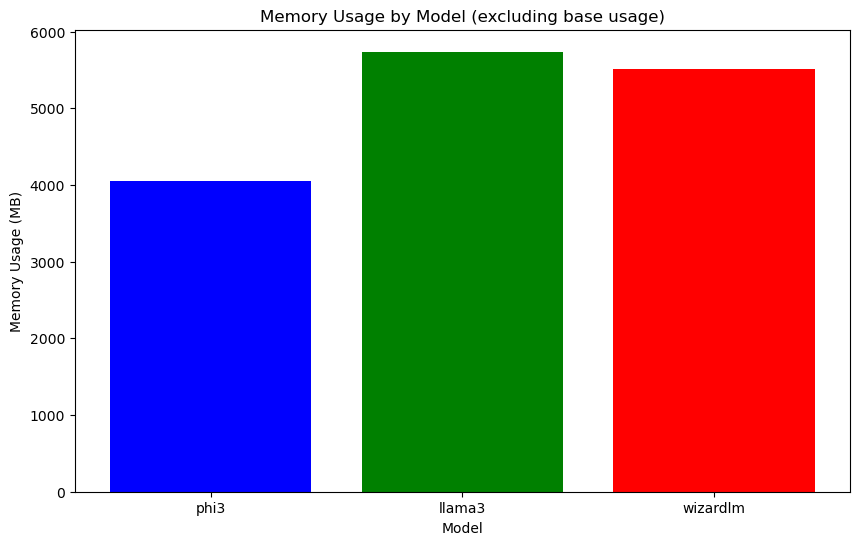

In [10]:
# Base memory usage
base_memory_usage = 1889 # MB

# Compute gross memory measurements with nvidia-smi minus base usage
phi3_memory_usage = 5935 - base_memory_usage # MB
llama3_memory_usage = 7626 - base_memory_usage # MB
wizardlm_memory_usage = 7403 - base_memory_usage # MB

# Data for plotting
models = ['phi3', 'llama3', 'wizardlm']
memory_usage = [phi3_memory_usage, llama3_memory_usage, wizardlm_memory_usage]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usage, color=['blue', 'green', 'red'])

plt.title('Memory Usage by Model (excluding base usage)')
plt.xlabel('Model')
plt.ylabel('Memory Usage (MB)')
plt.show()

In [28]:
with open('results/tool-count-eval-m1-max.json', 'r') as file:
    data = json.load(file)

In [29]:
records = []

for tool_count, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'tool_count': tool_count,
            'tool': tool,
            'median_latency': metrics['median_latency'],
            'pass_percentage': metrics['pass_percentage'],
        })

df = pd.DataFrame(records)

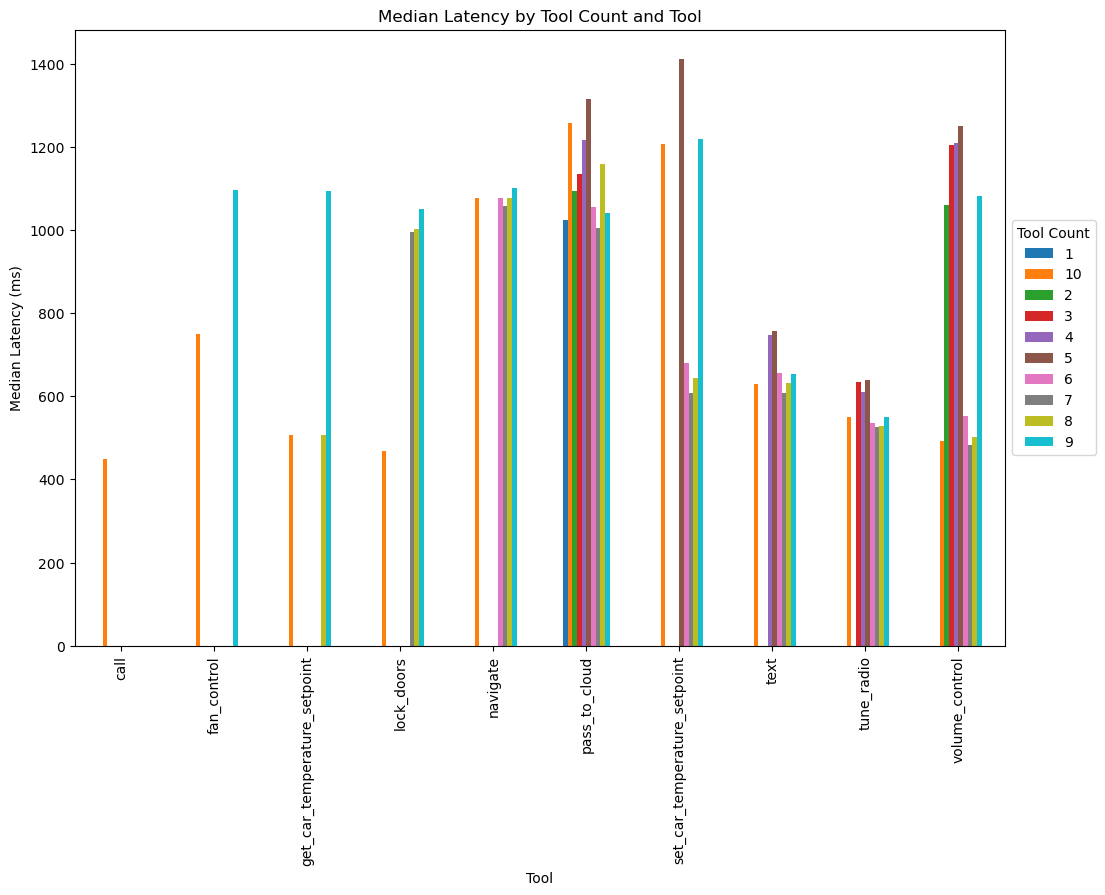

In [30]:
# Pivot the DataFrame to have tool counts as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='tool_count', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

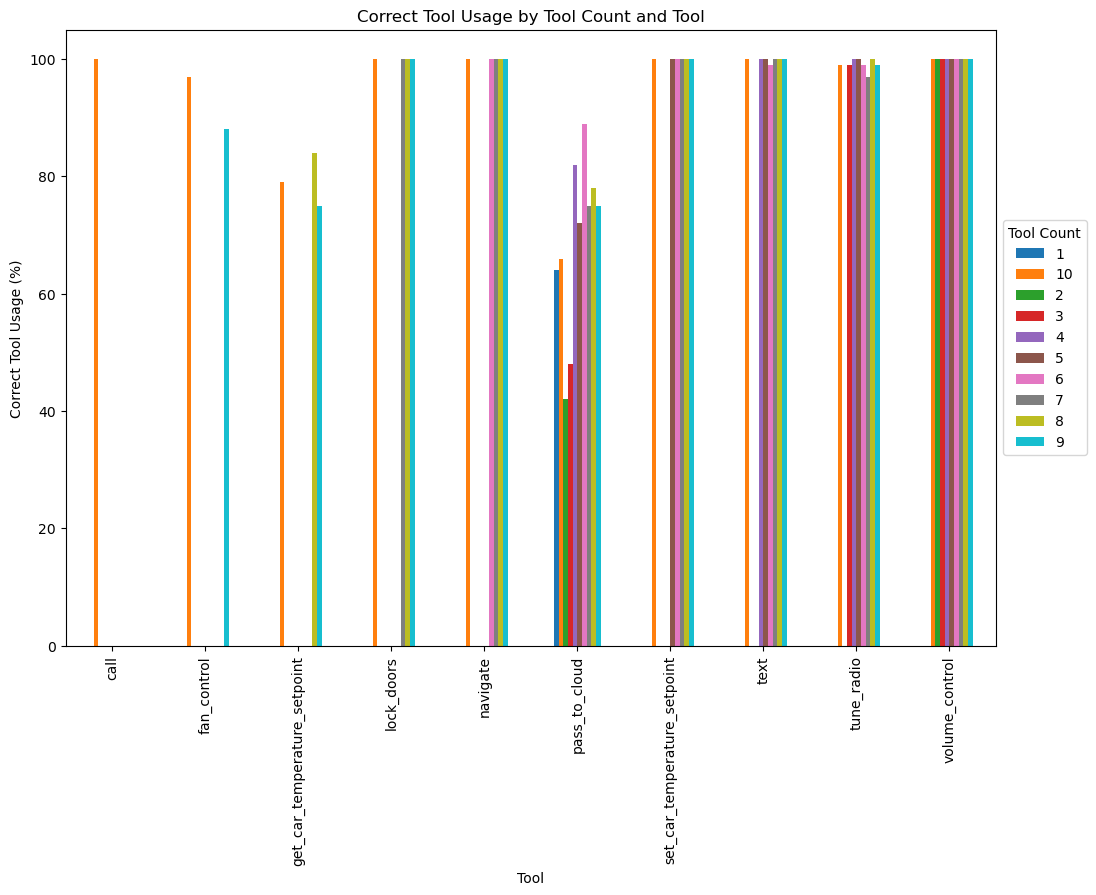

In [31]:
pivot_df = df.pivot(index='tool', columns='tool_count', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Tool Usage by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Correct Tool Usage (%)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

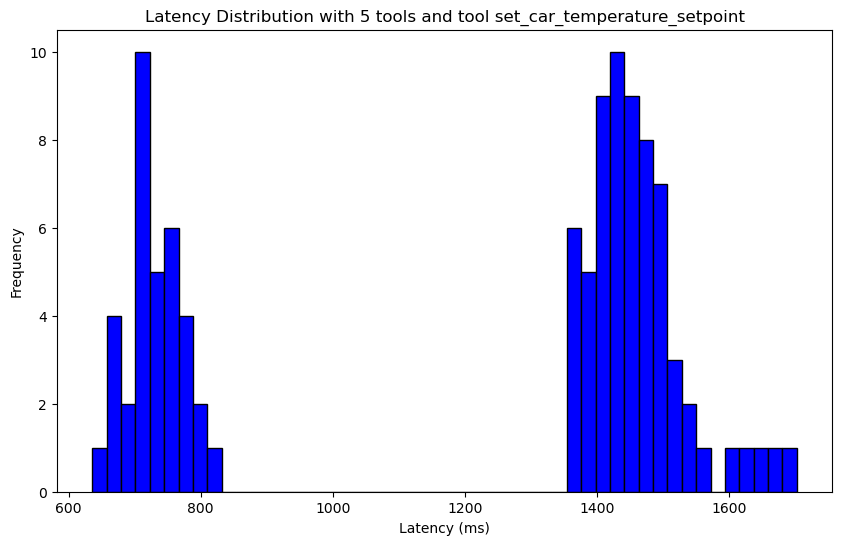

In [32]:
import numpy as np
import matplotlib.pyplot as plt

tool_count = '5'
tool_name = 'set_car_temperature_setpoint'

five_tool_count = data[tool_count]
latencies = five_tool_count[tool_name]['latencies']

# Create bins for the histogram
min_latency = min(latencies)
max_latency = max(latencies)
bins = np.linspace(min_latency, max_latency, 50)

# Plotting the latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=bins, edgecolor='black', color='blue')

plt.title(f'Latency Distribution with {tool_count} tools and tool {tool_name}')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Are there user inputs that are more likely to fail?
# How does hardware effect latency (4800 vs. M1 Max vs M4)?